In [1]:
import jax
import numpy as np
import jax.numpy as jnp
from functools import partial
from jax import jacfwd, jacrev
import matplotlib.pyplot as plt
import jax.scipy.linalg as jlinalg

jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

from parsmooth import MVNStandard
from parsmooth import FunctionalModel
from parsmooth.sequential._filtering import filtering
from parsmooth.linearization import extended, extended_hessian
from parsmooth.sequential._filtering_Newton import filtering as newton_filtering

In [2]:
def dynamic_model(xk):
    return jnp.tanh(xk)
def measurement_model(xk):
    return jnp.sin(xk)

In [3]:
# Get data
T = 60
xs = np.zeros((T, 1))
ys = np.zeros((T, 1))
sigma = 0.1
x0 = np.random.normal(loc=0, scale=1)
x = x0
xs[0] = x
for k in range(T):
    q = np.random.normal(loc=0, scale=sigma)
    r = np.random.normal(loc=0, scale=sigma)
    x = dynamic_model(x) + q
    y = measurement_model(x) + r
    xs[k] = x
    ys[k] = y

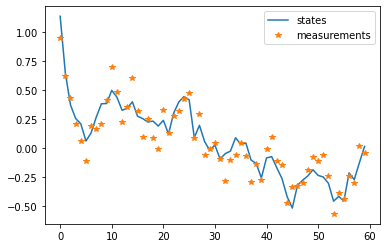

In [4]:
plt.figure()
plt.plot(xs)
plt.plot(ys, '*')
plt.legend(['states', 'measurements']);

In [5]:
Q = jnp.array([[sigma**2]])
R = jnp.array([[sigma**2]])
initial_states =  MVNStandard(jnp.repeat(jnp.array([[3.]]),T + 1, axis=0),
                                                     jnp.repeat(jnp.eye(1).reshape(1, 1, 1), T + 1, axis=0))
transition_model = FunctionalModel(partial(dynamic_model), MVNStandard(jnp.zeros((1,)), Q))
observation_model = FunctionalModel(partial(measurement_model), MVNStandard(jnp.zeros((1,)), R))

In [6]:
# Filtering - Gauss-Newton
m0 = dynamic_model(xs[0])
P0 = Q
init = MVNStandard(m0, P0)

xf = filtering(ys, init, transition_model, observation_model, extended, initial_states)


In [7]:
# Filtering - Newton
filtered_states_newton = newton_filtering(ys, init, transition_model, observation_model, extended_hessian, initial_states, False)

[[15.34777785]]
[[10.62732235]]
[[8.02405481]]
[[4.82913881]]
[[2.81477822]]
[[0.30549508]]
[[4.61204656]]
[[4.260519]]
[[4.8837737]]
[[7.75567466]]
[[11.80308752]]
[[8.7534126]]
[[5.10436175]]
[[6.89169798]]
[[10.46158594]]
[[6.42250665]]
[[3.27401227]]
[[5.46920244]]
[[3.10551991]]
[[1.74021961]]
[[6.51597024]]
[[3.77788532]]
[[5.77833581]]
[[6.44293653]]
[[7.89660183]]
[[8.61114319]]
[[3.10391176]]
[[6.02589427]]
[[1.00577936]]
[[1.78126018]]
[[2.49415993]]
[[0.60299387]]
[[-2.04898073]]
[[0.44632512]]
[[1.0238335]]
[[2.57424307]]
[[0.91239303]]
[[-2.1862282]]
[[-0.04925799]]
[[-1.97543122]]
[[1.78568076]]
[[3.24159529]]
[[0.36741727]]
[[-0.10575218]]
[[-4.72492412]]
[[-2.80520928]]
[[-2.74683021]]
[[-2.36568288]]
[[-0.72455435]]
[[0.76471438]]
[[0.31796253]]
[[1.08226309]]
[[-1.49821817]]
[[-6.11367447]]
[[-3.56713523]]
[[-4.2643159]]
[[-1.55119212]]
[[-2.29175961]]
[[2.12759944]]
[[1.30123304]]


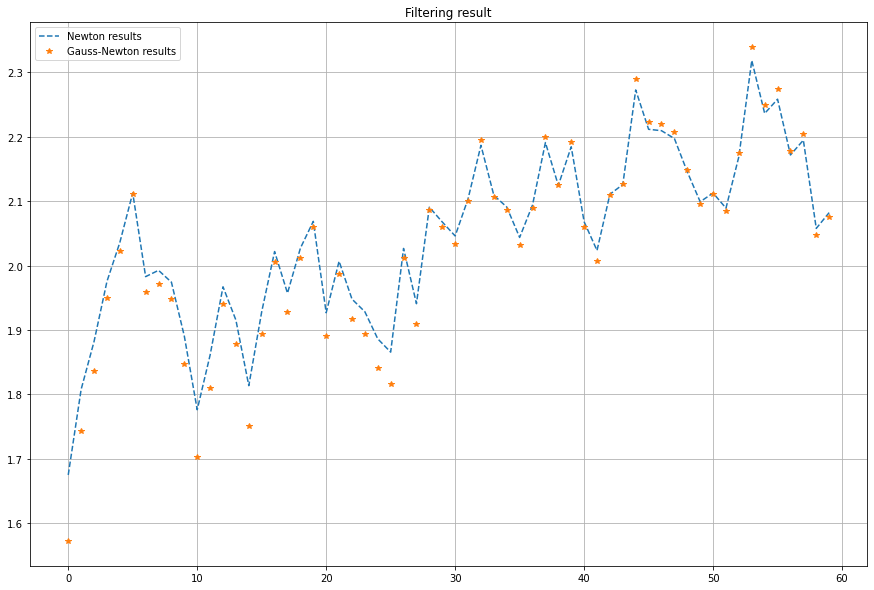

In [8]:
plt.figure(figsize=(15,10))
plt.plot(filtered_states_newton.mean[1:], "--", label="Newton results" )
plt.plot(xf.mean[1:], "*", label = "Gauss-Newton results")
plt.title("Filtering result")
plt.grid()
plt.legend();

# Batch solution

In [9]:
def mvn_loglikelihood(x, chol_cov):
    """multivariate normal"""
    dim = chol_cov.shape[0]
    y = jlinalg.solve_triangular(chol_cov, x, lower=True)
    normalizing_constant = (
            jnp.sum(jnp.log(jnp.abs(jnp.diag(chol_cov)))) + dim * jnp.log(2 * jnp.pi) / 2.0
    )
    norm_y = jnp.sum(y * y, -1)
    return -0.5 * norm_y - normalizing_constant

### Compute gradient and the full hessian

In [10]:
def LL(predict_trajectory, update_trajectory, z, measurement_fun, dynamic_fun, chol_Q, chol_R):
    mp_nominal = predict_trajectory
    mu_nominal = update_trajectory
    cost = mvn_loglikelihood(mu_nominal - dynamic_fun(mp_nominal), chol_Q) + mvn_loglikelihood(z - measurement_fun(mu_nominal), chol_R)
    return -cost

def lost_function(x):
    x0 = x[0]
    predict_traj =x[:-1]
    update_traj = x[1:]
    vmapped_fun = jax.vmap(LL, in_axes=[0, 0, 0, None, None, None, None])
    return jnp.sum(vmapped_fun(predict_traj, update_traj, ys, measurement_model, dynamic_model, jnp.linalg.cholesky(Q), jnp.linalg.cholesky(R))) - mvn_loglikelihood(x0 - m0, jnp.linalg.cholesky(P0))

grad = jax.grad(lost_function, argnums=0)(initial_states.mean)
Hess = jacfwd(jacrev(lost_function))(initial_states.mean)

In [11]:
x_batch = initial_states.mean - jax.numpy.linalg.tensorsolve(Hess, grad)

In [12]:
N = initial_states.mean.shape[0]
jnp.linalg.eigvals(jnp.reshape(Hess, (N,N) ))

DeviceArray([103.93744654+0.j, 213.57753856+0.j, 210.32645159+0.j,
             208.80704863+0.j, 208.95354984+0.j, 206.83464195+0.j,
             207.54561155+0.j, 205.98730749+0.j, 205.84637152+0.j,
             205.92215202+0.j, 205.11186246+0.j, 205.12475632+0.j,
             204.65075229+0.j, 204.56570369+0.j, 204.46262439+0.j,
             203.8585615 +0.j, 203.98383138+0.j, 203.01192502+0.j,
             202.70175403+0.j, 203.18529636+0.j, 202.46134254+0.j,
             191.34619533+0.j, 192.64686262+0.j, 192.9908496 +0.j,
             202.02189761+0.j, 201.15635904+0.j, 201.5581373 +0.j,
             201.43550688+0.j, 201.47136408+0.j, 201.09933585+0.j,
             200.65350273+0.j, 200.70936696+0.j, 200.58644809+0.j,
             199.95476146+0.j, 200.27134445+0.j, 199.76585991+0.j,
             199.6984265 +0.j, 200.54674994+0.j, 197.77346335+0.j,
             199.03896536+0.j, 199.38576358+0.j, 198.97354379+0.j,
             198.88461152+0.j, 198.57456535+0.j, 198.37043391+

In [13]:
# N = initial_states.mean.shape[0]
# x_batch_ = initial_states.mean - jnp.linalg.inv(jax.numpy.reshape(Hess, (N,N))) @ grad

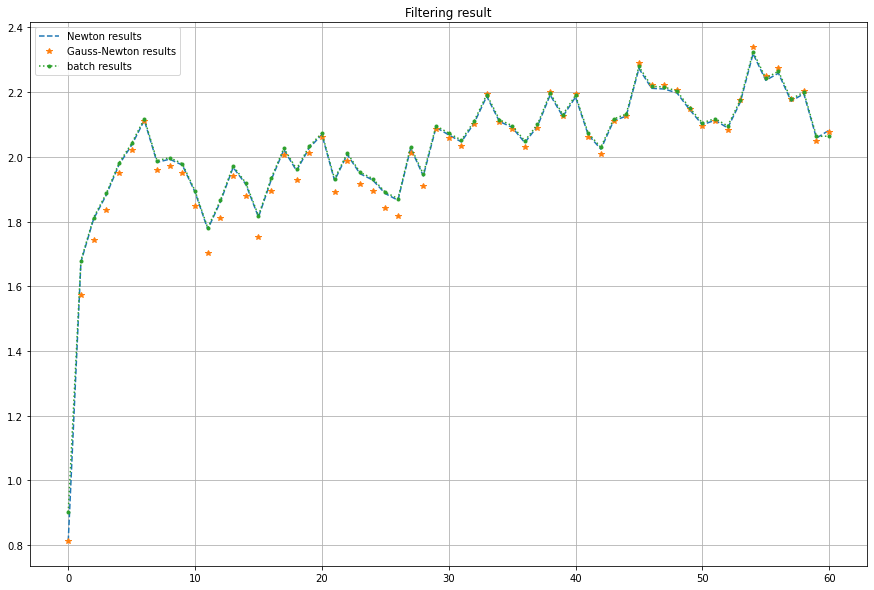

In [14]:
plt.figure(figsize=(15,10))
plt.plot(filtered_states_newton.mean, "--", label="Newton results" )
plt.plot(xf.mean, "*", label = "Gauss-Newton results")
plt.plot(x_batch, ".:", label = "batch results")
plt.title("Filtering result")
plt.grid()
plt.legend();

In [15]:
f0 = lambda x:  -mvn_loglikelihood(x - m0, jnp.linalg.cholesky(P0))

In [16]:
jax.grad(f0, argnums=0)(initial_states.mean[1])

DeviceArray([218.74400076], dtype=float64)

In [17]:
filtered_states_newton.mean

DeviceArray([[0.81255999],
             [1.67499869],
             [1.80780619],
             [1.88201986],
             [1.97527178],
             [2.03581973],
             [2.11268777],
             [1.98281436],
             [1.99260479],
             [1.97419676],
             [1.89051028],
             [1.7761876 ],
             [1.86106564],
             [1.96705242],
             [1.91537852],
             [1.81357404],
             [1.92824902],
             [2.02178296],
             [1.95710561],
             [2.02698255],
             [2.06862819],
             [1.92676416],
             [2.00670049],
             [1.94797258],
             [1.92830414],
             [1.88624807],
             [1.86563781],
             [2.02658179],
             [1.94083334],
             [2.09065317],
             [2.0676931 ],
             [2.04595121],
             [2.10355892],
             [2.18665886],
             [2.10908963],
             [2.09093406],
             [2.04364561],
 

In [18]:
x_batch

DeviceArray([[0.90210028],
             [1.67921848],
             [1.81207981],
             [1.88679048],
             [1.98040966],
             [2.04138102],
             [2.11766934],
             [1.98774349],
             [1.99745016],
             [1.97861826],
             [1.89432743],
             [1.78033813],
             [1.86577832],
             [1.97159119],
             [1.91939227],
             [1.81806898],
             [1.9332776 ],
             [2.02657013],
             [1.96218425],
             [2.03231857],
             [2.07329938],
             [1.93171748],
             [2.01142938],
             [1.95256156],
             [1.93267558],
             [1.89049547],
             [1.87063859],
             [2.0312944 ],
             [1.94620701],
             [2.09604069],
             [2.07295479],
             [2.05148096],
             [2.10954975],
             [2.19233535],
             [2.11460702],
             [2.09620297],
             [2.04912646],
 

### Compute gradient and non-zero elements of hessian

In [19]:
# cost at step 0
def ell_first(x_k_0):
    return  - mvn_loglikelihood(x_k_0 - m0, jnp.linalg.cholesky(P0))

# cost at step k
def ell(x_k, x_k_m_1, z_k, measurement_fun, dynamic_fun, chol_Q, chol_R):
    prior = mvn_loglikelihood(x_k - dynamic_fun(x_k_m_1), chol_Q)
    log_pdf = mvn_loglikelihood(z_k - measurement_fun(x_k), chol_R)
    return -prior - log_pdf

# The whole cost
def L(traj, obs, measurement_fun, dynamic_fun, chol_Q, chol_R):
    xs_k, xs_k_m_1 = traj[1:], traj[:-1]
    vmap_ell = jax.vmap(ell, (0, 0, 0, None, None, None, None))
    ells = vmap_ell(xs_k, xs_k_m_1, obs, measurement_fun, dynamic_fun, chol_Q, chol_R)
    return jnp.sum(ells) + ell_first(traj[0])

# gradient
def grad_L(traj, obs, measurement_fun, dynamic_fun, chol_Q, chol_R):
    return jax.grad(L)(traj, obs, measurement_fun, dynamic_fun, chol_Q, chol_R)

# hessian
def hess_L(traj, obs, measurement_fun, dynamic_fun, chol_Q, chol_R):
    def hess_util(x_k, x_k_p_1, x_k_m_1, z_k, z_k_p_1):
        one = ell(x_k, x_k_m_1, z_k, measurement_fun, dynamic_fun, chol_Q, chol_R)
        two = ell(x_k_p_1, x_k, z_k_p_1, measurement_fun, dynamic_fun, chol_Q, chol_R)
        return one + two

    hess_diag_fn = jax.vmap(jax.jacfwd(jax.jacrev(hess_util)), (0, 0, 0, 0, 0))

    hess_diag =  hess_diag_fn(traj[1:-1], traj[2:], traj[:-2], obs[:-1], obs[1:])

    hess_off_diag_fn = jax.vmap(jax.jacfwd(jax.jacrev(hess_util, argnums=1)), (0, 0, 0, 0, 0))
    hess_off_diag =  hess_off_diag_fn(traj[1:-1], traj[2:], traj[:-2], obs[:-1], obs[1:])
    return hess_diag, hess_off_diag



In [20]:
grad_L(initial_states.mean, ys, measurement_model, dynamic_model, jnp.linalg.cholesky(Q), jnp.linalg.cholesky(R))

DeviceArray([[216.76591433],
             [278.56797078],
             [245.45278328],
             [227.19020405],
             [204.7770614 ],
             [190.64581314],
             [173.04255821],
             [203.25410448],
             [200.78804983],
             [205.16033893],
             [225.3074495 ],
             [253.70107289],
             [232.3068331 ],
             [206.70781986],
             [219.24643489],
             [244.29010051],
             [215.95493918],
             [193.867456  ],
             [209.2672694 ],
             [192.68543954],
             [183.1075131 ],
             [216.61060987],
             [197.40225267],
             [211.4359181 ],
             [216.09826   ],
             [226.29608916],
             [231.30877728],
             [192.67415792],
             [213.17260318],
             [177.9552293 ],
             [183.39542305],
             [188.39659488],
             [175.12958735],
             [156.52531574],
             [

In [21]:
initial_states.mean[0].shape

(1,)

In [22]:
jax.jacfwd(jax.jacrev(ell_first, argnums=0))(initial_states.mean[0])

DeviceArray([[100.]], dtype=float64)

In [23]:
hess_L(initial_states.mean, ys, measurement_model, dynamic_model, jnp.linalg.cholesky(Q), jnp.linalg.cholesky(R))

(DeviceArray([[[213.36592605]],
 
              [[208.64547055]],
 
              [[206.04220301]],
 
              [[202.84728701]],
 
              [[200.83292642]],
 
              [[198.32364328]],
 
              [[202.63019477]],
 
              [[202.2786672 ]],
 
              [[202.9019219 ]],
 
              [[205.77382286]],
 
              [[209.82123572]],
 
              [[206.7715608 ]],
 
              [[203.12250995]],
 
              [[204.90984618]],
 
              [[208.47973414]],
 
              [[204.44065485]],
 
              [[201.29216047]],
 
              [[203.48735064]],
 
              [[201.12366811]],
 
              [[199.75836781]],
 
              [[204.53411844]],
 
              [[201.79603352]],
 
              [[203.79648401]],
 
              [[204.46108473]],
 
              [[205.91475003]],
 
              [[206.62929139]],
 
              [[201.12205996]],
 
              [[204.04404247]],
 
              [[199.02392757]],
 
              

In [24]:
Hess

DeviceArray([[[[103.94634248],
               [ -0.98660372],
               [  0.        ],
               ...,
               [  0.        ],
               [  0.        ],
               [  0.        ]]],


             [[[ -0.98660372],
               [213.36592605],
               [ -0.98660372],
               ...,
               [  0.        ],
               [  0.        ],
               [  0.        ]]],


             [[[  0.        ],
               [ -0.98660372],
               [208.64547055],
               ...,
               [  0.        ],
               [  0.        ],
               [  0.        ]]],


             ...,


             [[[  0.        ],
               [  0.        ],
               [  0.        ],
               ...,
               [195.7263886 ],
               [ -0.98660372],
               [  0.        ]]],


             [[[  0.        ],
               [  0.        ],
               [  0.        ],
               ...,
               [ -0.9866037